This notebook attempts to study on the given flight delay claim dataset from 2013/01 to 2016/07, which a model would be built to predict claim amount of future flights.

In [1]:
# Used libraries
import pandas as pd
from datetime import datetime

%matplotlib notebook

In [2]:
# Load the dataset
data_df = pd.read_csv('../datasets/flight_delays_data.csv')

# Check data size
data_df.shape

(899114, 10)

In [3]:
# Show some sample data
data_df.head()

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0
3,1582508,LD327,37,HKG,SIN,LD,3,0.1,2013-09-15,0
4,1582509,KA5390,40,HKG,PEK,KA,9,0.5,2015-10-05,0


We first study the basics of the given dataset:

In [4]:
# Check cardinality of different columns
data_df.apply(pd.Series.nunique)

flight_id      899114
flight_no        2344
Week               52
Departure           1
Arrival           163
Airline           122
std_hour           24
delay_time        379
flight_date      1065
is_claim            2
dtype: int64

In [5]:
# Check is_claim column values
data_df.is_claim.unique()

array([  0, 800], dtype=int64)

In [6]:
# Inspect records for is_claim that are not zero
data_df[~(data_df['is_claim'] == 0)].sort_values(['delay_time'], ascending=False).head()

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim
69,1582680,CX5974,19,HKG,PEK,CX,16,Cancelled,2014-05-12,800
535145,1665338,DL282,10,HKG,SEA,DL,13,Cancelled,2016-03-08,800
536233,1668673,CA6532,34,HKG,WUH,CA,8,Cancelled,2015-08-23,800
536228,1668656,KA1102,29,HKG,PEK,KA,12,Cancelled,2014-07-18,800
536181,1668493,CA710,19,HKG,TSN,CA,18,Cancelled,2015-05-13,800


In [7]:
# For records that declared the claim and is due to delay, check delay_time statistics
data_df[~(data_df['is_claim'] == 0) & ~(data_df['delay_time'] == 'Cancelled')]['delay_time'].apply(lambda x: float(x)).describe()

count    13721.000000
mean         6.977480
std          5.156125
min          3.000000
25%          3.500000
50%          4.500000
75%          8.200000
max         24.300000
Name: delay_time, dtype: float64

Some highlights from the basic study:
- All records are departed from HKG, and arrived to 163 different cities from 122 airlines
- is_claim only consists of two values in the dataset: 0 or 800
- When is_claim equals to 800, delay_time is either a real value >= 3.0, or marked as "Cancelled"

In [21]:
# Before proceeding the study, create new columns that helps with the dataset study

# flight date+year/month/day
data_df['flight_dt'] = data_df['flight_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data_df['flight_year'] = data_df['flight_dt'].apply(lambda x: x.year)
data_df['flight_month'] = data_df['flight_dt'].apply(lambda x: x.month)
data_df['flight_day'] = data_df['flight_dt'].apply(lambda x: x.day)

# flight_type: With three categories (Normal/Cancelled/Delayed)
def get_flight_type(delay_time):
    if delay_time == "Cancelled":
        return "Cancelled"
    elif float(delay_time) >= 3.0:
        return "Delayed"
    else:
        return "Normal"
    
data_df['flight_type'] = data_df['delay_time'].apply(get_flight_type)

In [22]:
# Check resulting dataframe
data_df.sample(10)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,flight_year,flight_type,flight_dt,flight_month,flight_day
654353,2033900,CA6522,8,HKG,PEK,CA,14,0.1,2015-02-24,0,2015,Normal,2015-02-24,2,24
511581,1592083,CX257,19,HKG,LHR,CX,9,0.6,2014-05-12,0,2014,Normal,2014-05-12,5,12
233072,724093,AC6265,48,HKG,NRT,AC,15,0.0,2013-12-01,0,2013,Normal,2013-12-01,12,1
469812,1461478,MU504,17,HKG,PVG,MU,15,2.9,2016-04-26,0,2016,Normal,2016-04-26,4,26
221451,687431,CX5974,12,HKG,PEK,CX,18,0.3,2015-03-23,0,2015,Normal,2015-03-23,3,23
654390,2034023,BA4131,29,HKG,SYD,BA,23,0.9,2016-07-18,0,2016,Normal,2016-07-18,7,18
303552,944173,CX466,51,HKG,TPE,CX,13,-0.1,2014-12-19,0,2014,Normal,2014-12-19,12,19
893674,2776460,CX7680,39,HKG,DFW,CX,13,0.4,2014-09-25,0,2014,Normal,2014-09-25,9,25
67432,208743,AA6124,23,HKG,EWR,AA,17,0.0,2014-06-06,0,2014,Normal,2014-06-06,6,6
459697,1430228,KA1104,30,HKG,TSN,KA,12,0.2,2014-07-28,0,2014,Normal,2014-07-28,7,28


In below section, we study the dataset using various graphs, and try to have some impressions on how the data denotes for claiming risk:

<IPython.core.display.Javascript object>


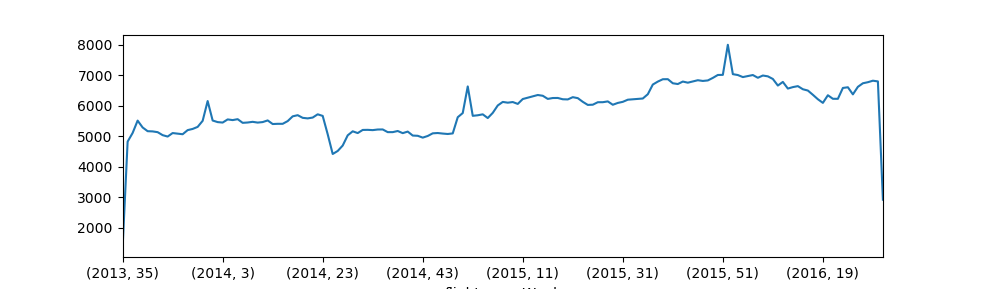

In [28]:
# Show flight row count against year + week
data_df.groupby(['flight_year', 'Week']).count()['flight_id'].plot()

<IPython.core.display.Javascript object>


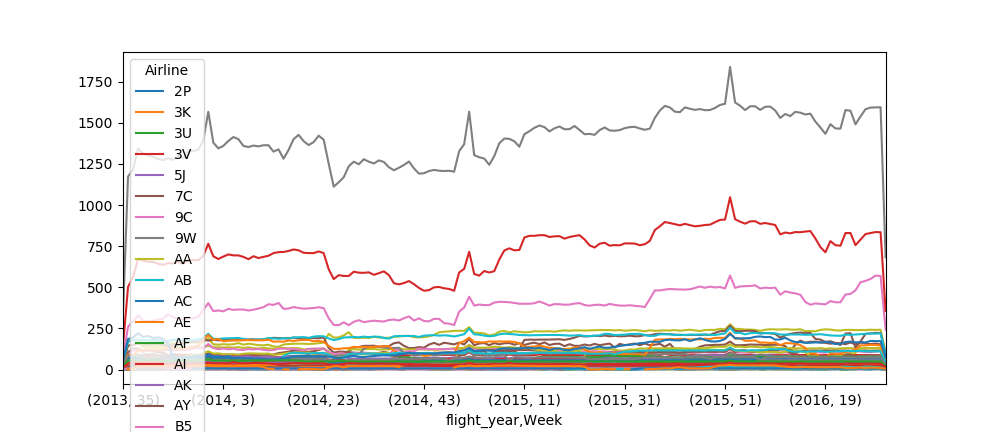

In [30]:
data_df.groupby(['flight_year', 'Week', 'Airline']).count()['flight_id'].unstack().plot()

<IPython.core.display.Javascript object>


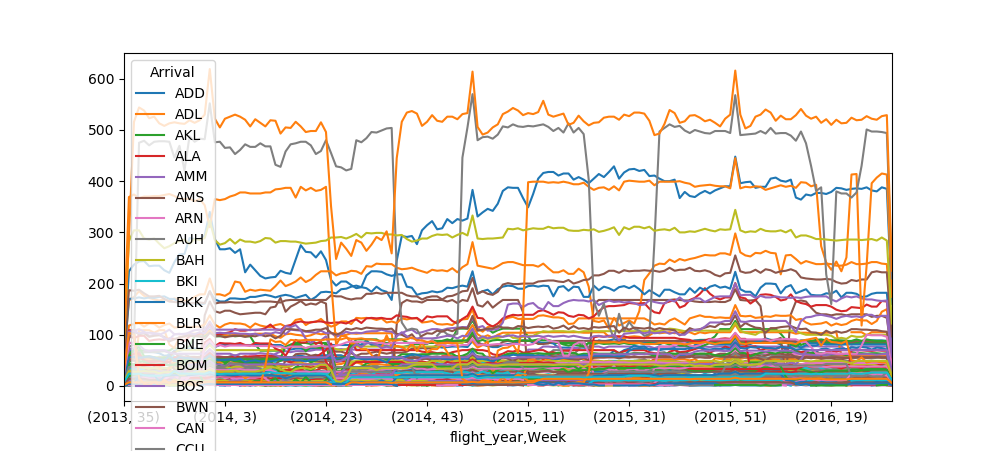

In [32]:
data_df.groupby(['flight_year', 'Week', 'Arrival']).count()['flight_id'].unstack().plot()

We saw that there is a seasonal trend for arranged flights during different weeks of a year (e.g. There is a peak of flights during year-end). Also, the increasing trend of arranged flights is more likely due to arrival airport rather than changes in airline comapanies.

<IPython.core.display.Javascript object>


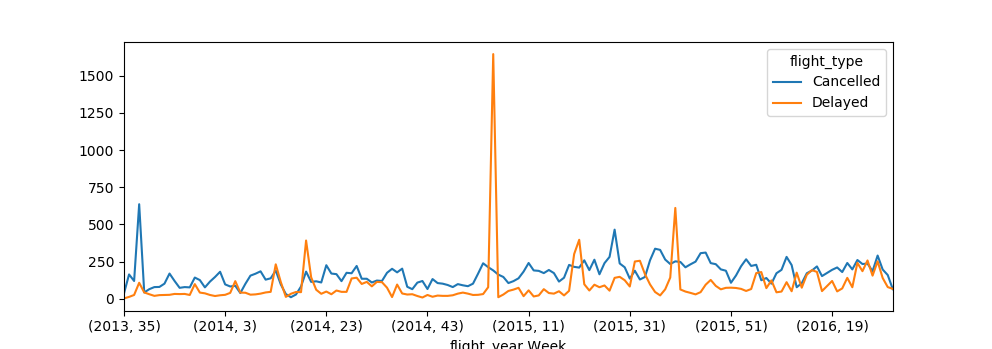

In [45]:
# Show flight row count with is_claim = 0 and is_claim = 800
abnormal_df = data_df[~(data_df['flight_type'] == "Normal")]
abnormal_df.groupby(['flight_year', 'Week', 'flight_type']).count()['flight_id'].unstack().plot.line()
# Multiple spikes appeared and have to check why they occur

<IPython.core.display.Javascript object>


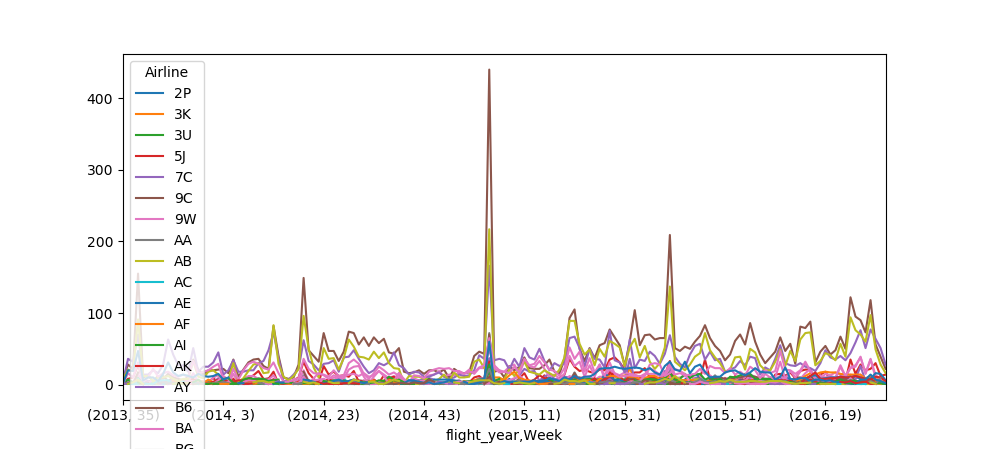

In [59]:
abnormal_df.groupby(['flight_year', 'Week', 'Airline']).count()['flight_id'].unstack().plot.line()

<IPython.core.display.Javascript object>


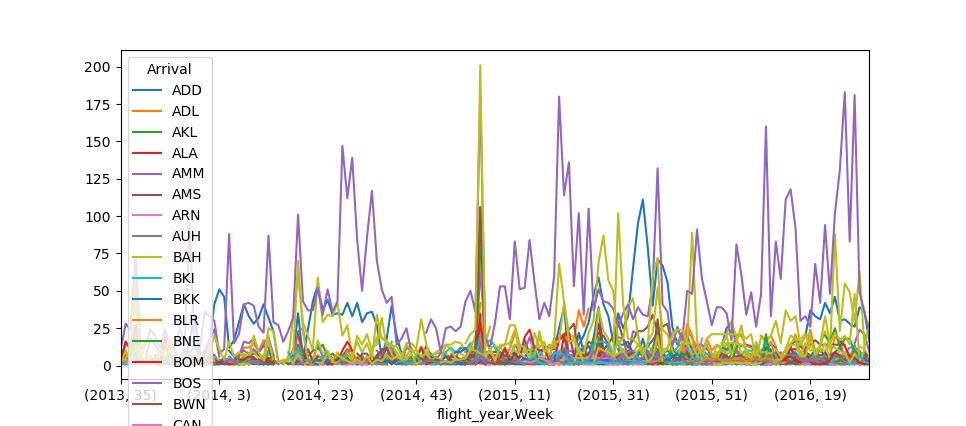

In [58]:
abnormal_df.groupby(['flight_year', 'Week', 'Arrival']).count()['flight_id'].unstack().plot.line()

Throughout the years, there are almost always having cancelled/delayed flights, and there are several major incidents that result in such a surge. 

When the surge of cancelled/delayed flights occurs, it can be seen from the graphs that usually all airlines (and arrival ports) appeared similar surge trend. Implying that the large surge is likely due to departure airport rather than airlines (and arrival ports) themselves.

We should also bear in mind that:
- The surge of cancelled/delayed flights is correlated with distribution of flights' arrival ports
- The surge of cancelled/delayed flights is also correlated with distribution of airlines. Airlines themselves can be a factor of cancelled/delayed flights (e.g. faulty system within airline/mis-management/etc.)

<IPython.core.display.Javascript object>


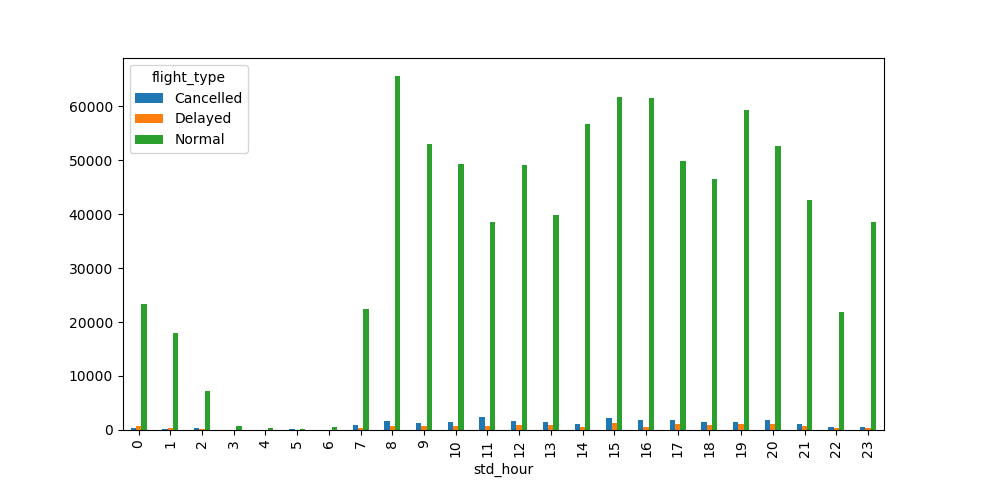

In [67]:
data_df.groupby(['std_hour', 'flight_type']).count()['flight_id'].unstack().plot.bar()

<IPython.core.display.Javascript object>


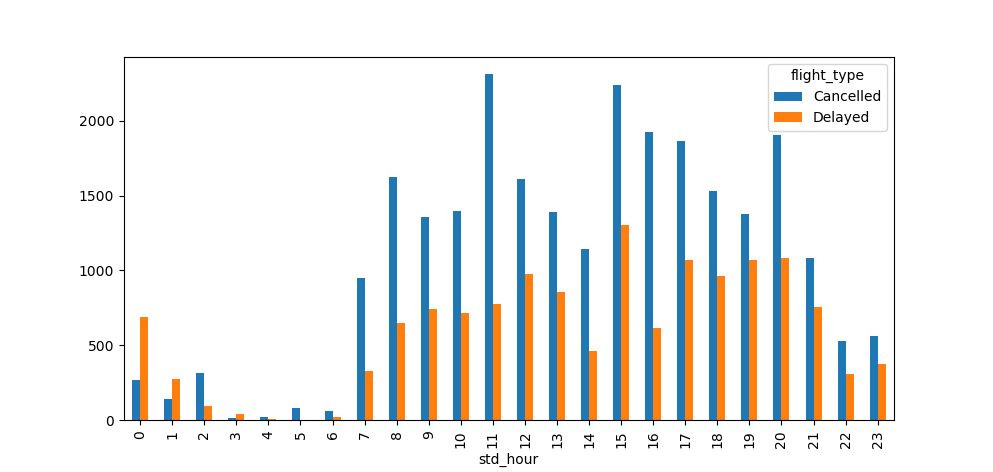

In [61]:
abnormal_df.groupby(['std_hour', 'flight_type']).count()['flight_id'].unstack().plot.bar()

In [65]:
data_count_df = data_df.groupby(['std_hour', 'flight_type']).count()['flight_id'].reset_index()

<IPython.core.display.Javascript object>


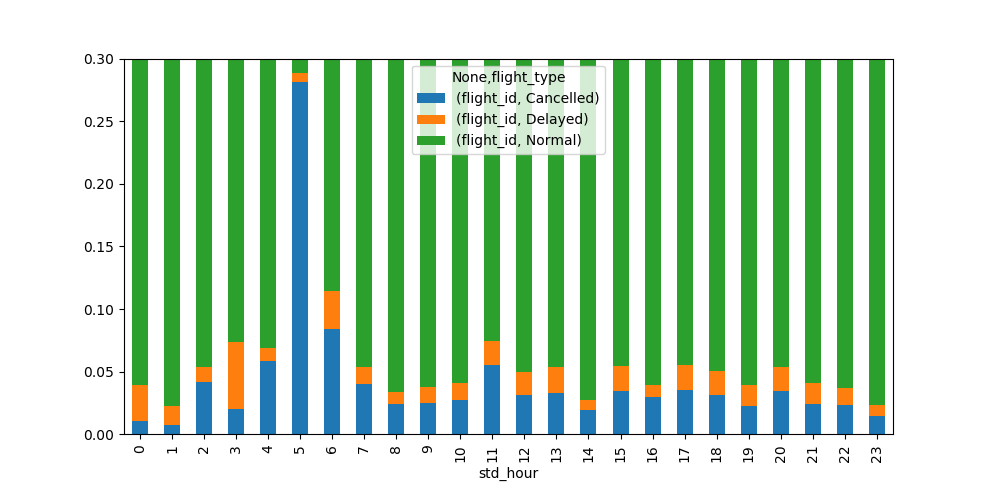

In [73]:
tps = data_count_df.pivot_table(values=['flight_id'], 
                          index='std_hour',
                          columns='flight_type',
                          aggfunc='sum')

tps = tps.div(tps.sum(1), axis=0)
tps.plot(kind='bar', stacked=True, ylim=(0, 0.3))

The cause of cancelled/delayed flights is related to when the flight starts. Although the graph shows that there are significantly less cancelled/delayed flights by midnight, it is also shown that the number of flights during those hours are much less as well. The 100% stacked bar shows the hour trend better as it considers ratio of different flight types rather than just by count.

In [ ]:
# Show again with flight_type: Normal, Cancelled, Delayed
# See if there are any abnormal situation (e.g. sudden surge on flight delays)

<IPython.core.display.Javascript object>


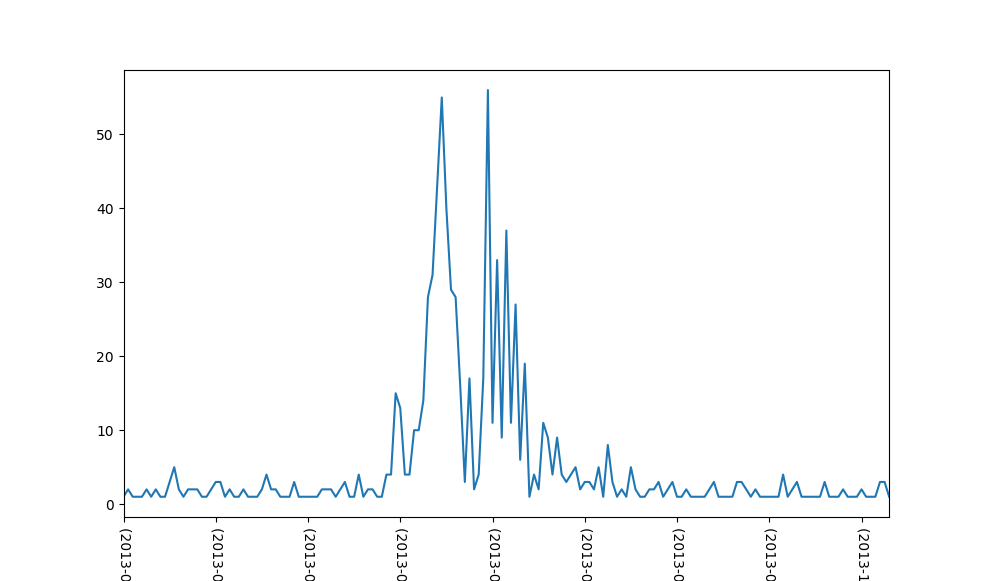

In [57]:
# 2013 Sept
typhoon_df = abnormal_df[(abnormal_df['flight_dt'] >= datetime(2013,9,15)) & (abnormal_df['flight_dt'] <= datetime(2013,10,1))]
typhoon_df.groupby(['flight_dt', 'std_hour', 'flight_type']).count()['flight_id'].plot.line(rot=270)
# Related news on super typhoon
# Source: https://www.scmp.com/news/hong-kong/article/1315301/typhoon-usagi-severe-storm-lashes-hong-kong
# http://www.hko.gov.hk/m/article_e.htm?title=ele_00459

It is hard to linkage all possible information that causes delay/cancellation. In below, we try to see flight trends from other perspectives:

In [1]:
# Per arrival airport flight trend
# Not always constant, bear in mind if we use week number only (or preprocessing might even be needed for those gaps)
# e.g. PVG sudden drops in no. of flights
# Something related to this: https://www.scmp.com/news/hong-kong/economy/article/1846653/hong-kongs-cathay-pacific-cancels-some-mainland-china-flights

In [ ]:
# Arrival airport congestion could be a factor of delay
# https://www.forbes.com/sites/ralphjennings/2017/06/06/hogging-of-space-explains-why-so-many-flights-still-take-off-late-in-china/#3f1d750e2610

In [ ]:
# Fix arrival port = ICN
# Shows slump in 2015 week 24-40
# Breakdown by 100% stack bar -> basically all airlines are affected => cause could be due to arrival airport problem
# If we have a way to translate such signal with something like rolling window on the arrival airport?

In [2]:
# Departure port could also impose disruption
# e.g. 2015 week 4, many, many flights are delayed

In [ ]:
# Zoom in 2015 week 4 details
# Date + std_hour against delay/cancel count

# Shows that std_hour can be a useful feature to determine if a flight could be disrupted
# e.g. By 100% stack bar, less flight delay/cancel per "after 3pm" vs. midnight

In [ ]:
# From departure port
# Zoom in 2015 week 4 details + line chart on delay hours

# We know that delay_hours of course infers how risky to delay/cancellation, but we won't have that in runtime
# Instead, we can only have historical data in runtime

Direct approach:
- Put week, Departure, Arrival, Airline, std_hour, predict delay_hours/is_claim with binary output * 800

Feature engineering approach:
- Last (4 hours/day/week/month) of (delay_hour rolling average) of (airline, departure, arrival)

In [ ]:
# Other news on weather related airport affect: https://edition.cnn.com/2016/12/04/asia/china-smog-stranded/

In [ ]:
# Linkage with airport geo-location
# Assumption: Even if airport disrupted, could geo-location compensate for delay hours?
# BUT: Arrival airport code infers the geo-location already
# https://openflights.org/data.html

Other links:

https://www.scmp.com/news/hong-kong/economy/article/2126184/best-and-worst-airlines-and-routes-revealed-database-26000
https://www.scmp.com/news/hong-kong/health-environment/article/2098076/can-you-fly-typhoon-heres-how-airlines-and